In [1]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook,tqdm
pd.set_option('max_row',1000)
pd.set_option('max_column',1000)

In [2]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input,Dense,Embedding,Flatten,concatenate, add, subtract
from keras.models import Model,Sequential
import matplotlib.pyplot as plt

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def read_and_drop():
    
    conn = MySQLdb.connect(host="127.0.0.1",
                                 user="root",
                                 passwd="root123",
                                 db="football",
                                 charset = 'utf8'
                        )
    # 从数据库读取数据
    leagues = pd.read_sql_query('select * from league',conn)
    match_stats = pd.read_sql_query('select * from match_stats', conn)
    matches = pd.read_sql_query('select * from matches', conn)
    teams = pd.read_sql_query('select * from team', conn)
    kickoff_handicaps = pd.read_sql_query('select * from kickoff_handicap',conn)
    
    # 删除无意义的字段
    to_drop_match_stats = ['create_time','update_time', 'first_half_time_corners','full_time_corners','full_time_goals','full_time_goals_against']
    match_stats = match_stats.drop(to_drop_match_stats, axis = 1)
    
    to_drop_matches = ['create_time','update_time', 'first_half_time_corners','full_time_corners']
    matches = matches.drop(to_drop_matches, axis = 1)
    
    to_drop_leagues = ['create_time','update_time','abbreviation','type','top']
    leagues = leagues.drop(to_drop_leagues, axis = 1)
    
    to_drop_teams = ['create_time','update_time']
    teams = teams.drop(to_drop_teams, axis = 1)
    
    to_drop_kickoff_handicaps = ['create_time','update_time','over_odds','under_odds']
    kickoff_handicaps = kickoff_handicaps.drop(to_drop_kickoff_handicaps, axis = 1)
    
    return matches, match_stats, leagues, teams, kickoff_handicaps


def data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps):
    '''
        DESC: 对每张表清洗数据，其中包括；
            1. 将分类变量转化为categorical类型，并提取code
            2. 合并表格
            3. 去除清洗过程中产生的多余字段
            4. 将字段转化为正确的数据类型
            
        Parameters:
            球赛数据需要的各类表格
            
        Returns:
            match_stats, 本表清洗过后合并的宽表，可以用来构造其他特征
    
    '''
    
    # women字段 one-hot encoding
    matches['women_cat'] = pd.Categorical(matches['women']).codes
    
    # match 表清洗， 与leagues表合并
    leagues.columns = ['league_id', 'league_name', 'league_type']
    matches = matches.drop(['league_type'], axis = 1).merge(leagues, on= 'league_id', how = 'left')
    clean_matches = matches[['id','league_id','women','women_cat','league_name','league_type']].copy()
    clean_matches.columns = ['match_id','league_id','women','women_cat','league_name','league_type']
    
    # match_stats表分类变量code提取
    match_stats['home_team_cat'] = pd.Categorical(match_stats['home_team']).codes
    match_stats['match_result_cat'] = pd.Categorical(match_stats['match_result']).codes
    match_stats['match_start_time'] = pd.to_datetime(match_stats['match_start_time'])
    
    # 总表字段重命名
    match_stats.columns = ['match_stats_id', 'attacks', 'dangerous_attacks', 'first_half_time_goals',
           'first_half_time_goals_against', 'home_team', 'league_id', 'match_id',
           'match_result', 'match_start_time', 'off_targets', 'on_targets',
           'red_cards', 'second_half_time_goals', 'second_half_time_goals_against',
           'shots', 'team_id', 'yellow_cards', 'home_team_cat',
           'match_result_cat']
    
    # match_stats与matches, teams， kickoffs 合并
    match_stats = match_stats.drop('league_id', axis = 1)
    match_stats = match_stats.merge(clean_matches, on = 'match_id', how = 'left')
    teams.columns = ['team_id','team_name']
    match_stats = match_stats.merge(teams, on = 'team_id', how = 'left')
    
    # pivot以后，两个盘口的数据变成字段，然后join
    kickoff_handicaps = kickoff_handicaps.pivot(index='match_id', columns='handicap_type', values='handicap_value')
    kickoff_handicaps.columns.name = None
    match_stats = match_stats.merge(kickoff_handicaps.reset_index(), on = 'match_id', how = 'left')
    
    match_stats['league_type_cat'] = pd.Categorical(match_stats['league_type']).codes
    
    # 将object字段转化为整数
    ints = ['match_id','team_id','league_id']
    for col in ints:
        match_stats[col] = match_stats[col].astype('int64')
    
    # 多分类变量 - one-hot encoding
    match_result_dummies = pd.get_dummies(match_stats['match_result_cat'],prefix='match_result_cat')    
    match_stats = pd.concat([match_stats, match_result_dummies], axis = 1)
        
    return match_stats.dropna()

In [4]:
matches, match_stats, leagues, teams, kickoff_handicaps = read_and_drop()
match_stats = data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps)
mapping_stats2league = {stats_id:league_id for stats_id, league_id  in match_stats[['match_stats_id','league_id']].values}

In [5]:
match_teams = match_stats[match_stats.match_result_cat_0 != 1][['match_id','team_id']].groupby('match_id').agg(lambda x:list(x))
match_teams['n_teams'] = match_teams['team_id'].apply(lambda x: len(x))
match_teams = match_teams[match_teams['n_teams'] == 2]
team_1 = match_teams['team_id'].apply(lambda x:x[0])
team_2 = match_teams['team_id'].apply(lambda x:x[1])
match_teams['team_1'] = team_1
match_teams['team_2'] = team_2
match_teams = match_teams.drop('team_id', axis = 1)
match_teams = match_teams.drop('n_teams', axis = 1)

In [6]:
womens = matches[['id','women_cat']]
womens.columns = ['match_id','women_cat']
womens['match_id'] = womens['match_id'].astype(int)
match_teams = match_teams.reset_index().merge(womens, on = 'match_id',how = 'left')

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
match_stats['wins'] = (match_stats['match_result_cat_2'] == 1).astype(int)
sub_stats = match_stats[match_stats.match_result_cat_0 != 1][['match_id','team_id','wins','home_team_cat']]
simple_data = match_teams.merge(sub_stats, left_on = ['match_id','team_1'], right_on = ['match_id','team_id'], how = 'left').drop('team_id',axis = 1)
team_ids = set(simple_data.team_1).union(set(simple_data.team_2))
n_teams = len(team_ids)

In [8]:
team2embed = {team_id:embed_id for embed_id, team_id in enumerate(team_ids)}
embed2team = {v:k for k, v in team2embed.items()}

In [9]:
simple_data['team_1'] = simple_data['team_1'].replace(team2embed)
simple_data['team_2'] = simple_data['team_2'].replace(team2embed)

In [10]:
simple_data['team_1'].max(), simple_data['team_2'].max()

(25033, 25033)

In [11]:
input_team_1 = Input(shape = (1,))
input_team_2 = Input(shape = (1,))
home = Input(shape=(1,))

# build an embedding block
inputs = Input(shape = (1,))
embedding_layer = Embedding(input_dim = n_teams,input_length = 1, output_dim = 1)
embedding_tensor = embedding_layer(inputs)
flatten_tensor = Flatten()(embedding_tensor)
embedding_block = Model(inputs, flatten_tensor)

embedding_team_1 = embedding_block(input_team_1)
embedding_team_2 = embedding_block(input_team_2)


concat_tensor = concatenate([embedding_team_1, embedding_team_2, home],axis = -1)
output_tensor = Dense(10,activation = 'relu')(concat_tensor)
output_tensor = Dense(1)(output_tensor)
model = Model([input_team_1, input_team_2,home],output_tensor)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            25034       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                      

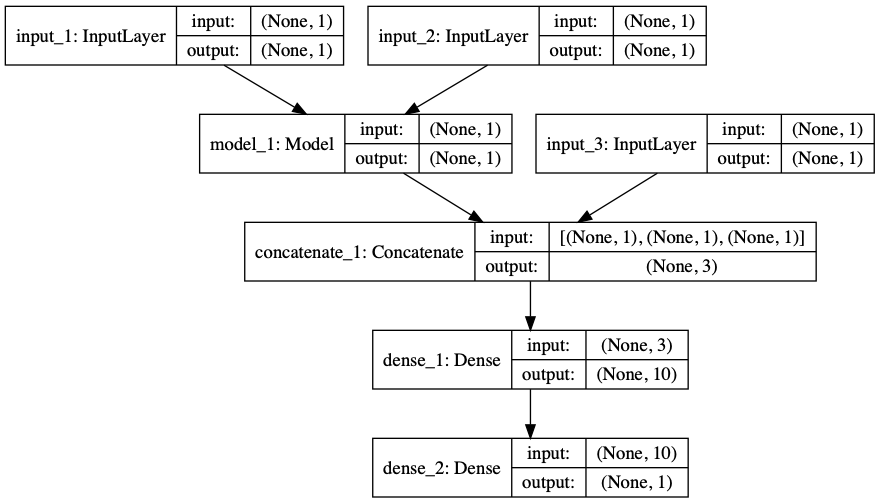

In [12]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [13]:
simple_data.to_csv('test_embed.csv',index =False)

In [14]:
simple_data.wins = simple_data.wins.astype('int64')
simple_data.women_cat = simple_data.women_cat.astype('int64')
simple_data.home_team_cat = simple_data.home_team_cat.astype('int64')

In [15]:
simple_data.dtypes

match_id         int64
team_1           int64
team_2           int64
women_cat        int64
wins             int64
home_team_cat    int64
dtype: object

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 238816 samples, validate on 59704 samples
Epoch 1/10
238816/238816 [==============================] - 3s 11us/step - loss: 0.5559 - accuracy: 0.7116 - val_loss: 0.7320 - val_accuracy: 0.6324
Epoch 2/10
238816/238816 [==============================] - 2s 10us/step - loss: 0.5514 - accuracy: 0.7138 - val_loss: 0.7648 - val_accuracy: 0.6343
Epoch 3/10
238816/238816 [==============================] - 2s 10us/step - loss: 0.5480 - accuracy: 0.7146 - val_loss: 0.8004 - val_accuracy: 0.6353
Epoch 4/10
238816/238816 [==============================] - 2s 10us/step - loss: 0.5456 - accuracy: 0.7162 - val_loss: 0.8052 - val_accuracy: 0.6364
Epoch 5/10
238816/238816 [==============================] - 2s 10us/step - loss: 0.5444 - accuracy: 0.7158 - val_loss: 0.8180 - val_accuracy: 0.6375
Epoch 6/10
238816/238816 [==============================] - 3s 11us/step - loss: 0.5422 - accuracy: 0.7171 - val_loss: 0.8408 - val_accuracy: 0.6364
Epoch 7/10
238816/238816 [=============================

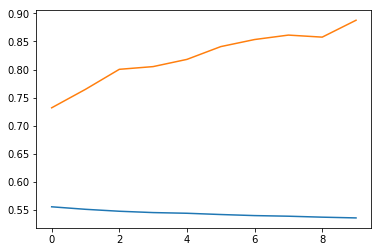

In [17]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
history = model.fit([simple_data['team_1'].values, simple_data['team_2'].values, simple_data['home_team_cat'].values],simple_data[['wins']].values,
                   batch_size = 128,epochs = 10,verbose = True,validation_split = 0.2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [42]:
team_strength = {embed2team[embed_id]:strength for embed_id, strength in enumerate(embedding_layer.get_weights()[0].flatten())}

In [44]:
import pickle
open('team_embedding.dic','wb').write(pickle.dumps(team_strength))

750401